In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.ThreeHeadCNN import ThreeHeadCNN
import helper_functions

c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
allow_train = False
load_pre_train_model = False
freeze_encoder = False
EPOCHS = 40
BATCH_SIZE = 128
shrink_size = None

lr = 1e-3
weight_deacay = 1e-4
T_max = 15
eta_min = 1e-4
num_augs = 20
p_dropout = 0.5
pos_weight = torch.tensor([3.0])

crop_size = 240

# weights for alpha is inverse frequency
# alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
# alpha = torch.tensor([0.25, 0.25, 0.25, 0.25, 0.25])

# alpha = [1] * 5
# alpha = [1/1805, 1/370, 1/999, 1/193, 1/295] * 500 
alpha = 1
gamma = 1

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms()
no_transforms = helper_functions.get_augmentation_no_transforms()

d:\Masoudi\University Project\DR_Project_Binary\helper_functions.py:234: UserWarning: `n` is greater than number of transforms. `n` will be set to 14.
  A.SomeOf([


In [5]:
# load all dataloaders

train_val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    shrink_size=shrink_size)

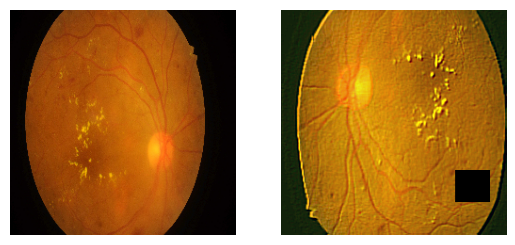

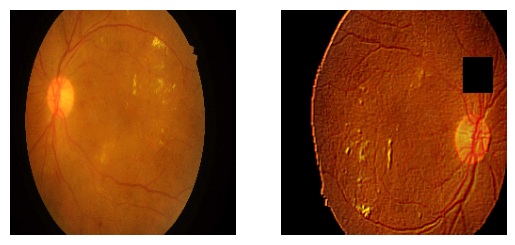

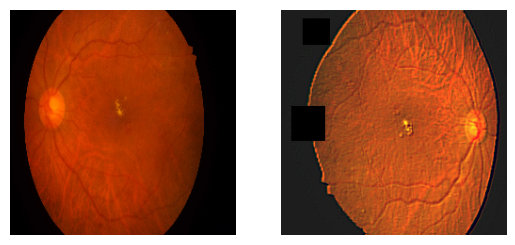

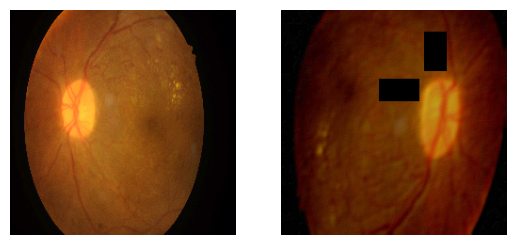

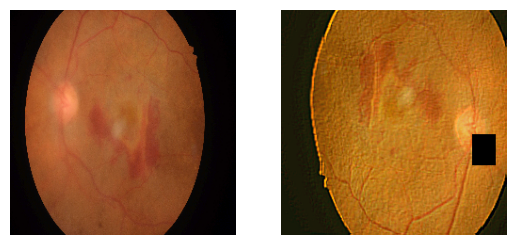

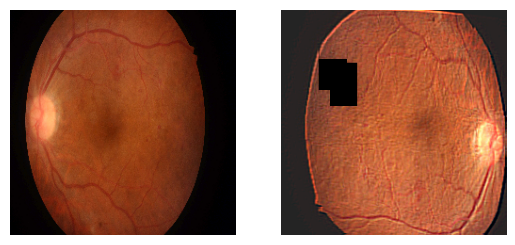

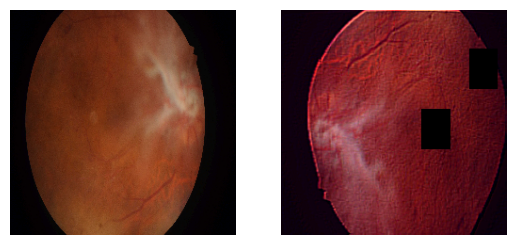

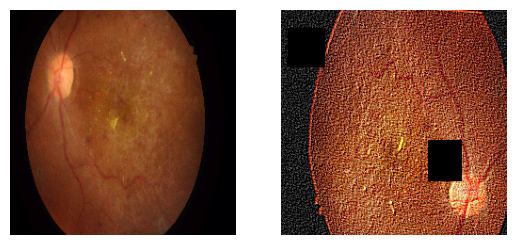

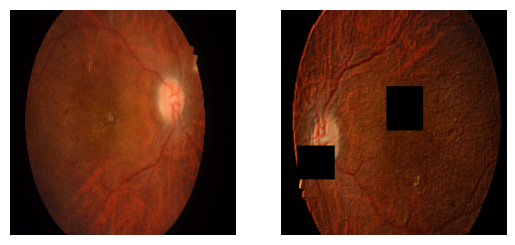

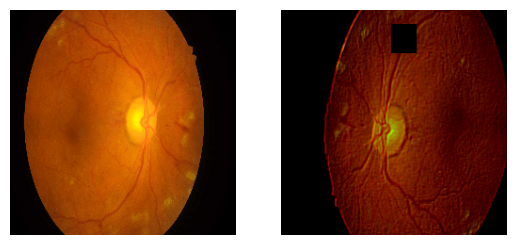

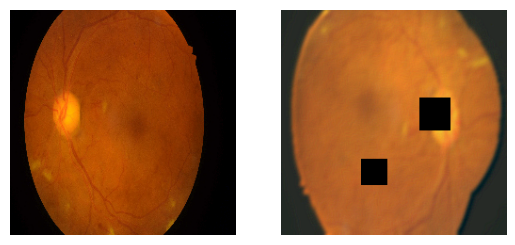

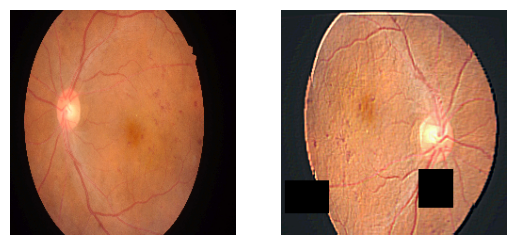

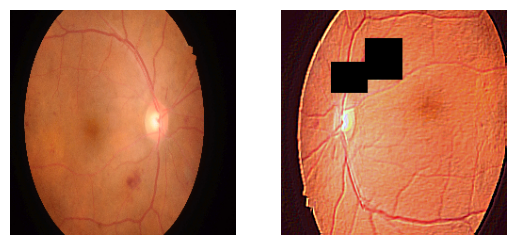

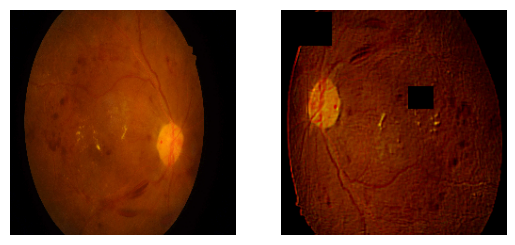

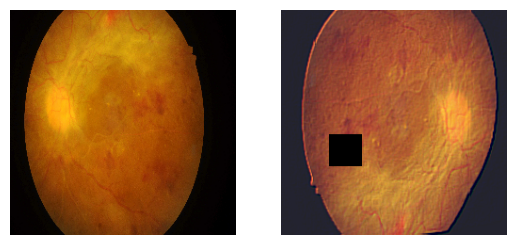

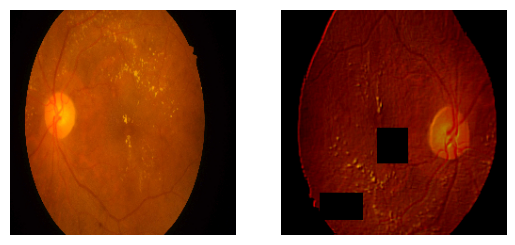

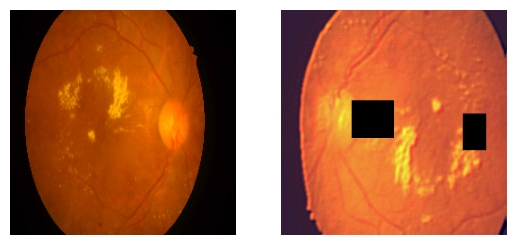

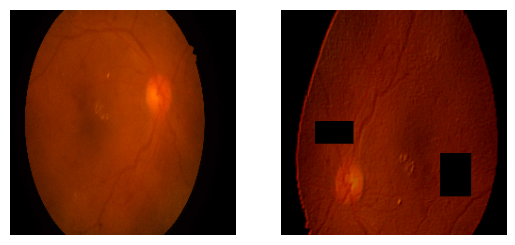

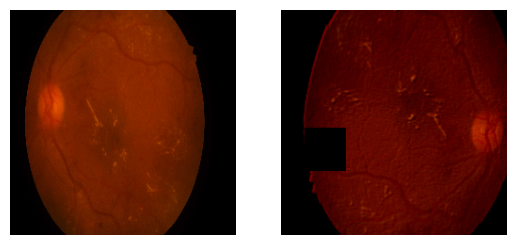

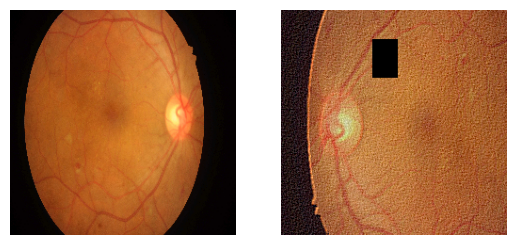

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(20):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()